/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:14:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8133


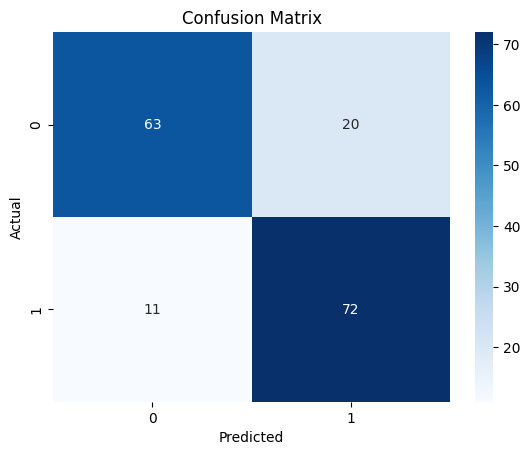

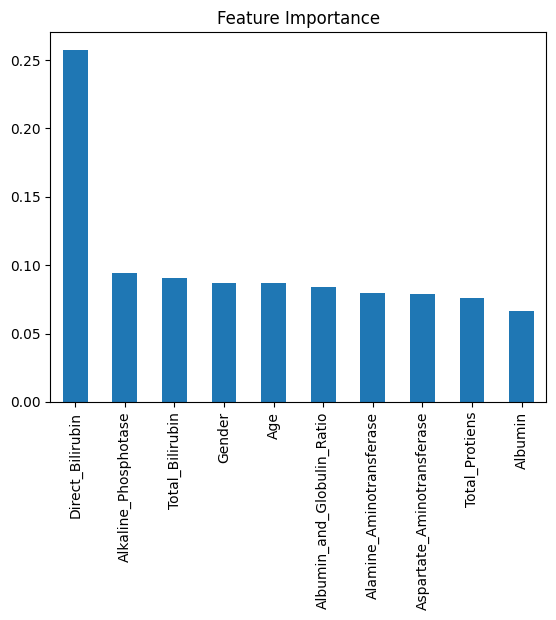

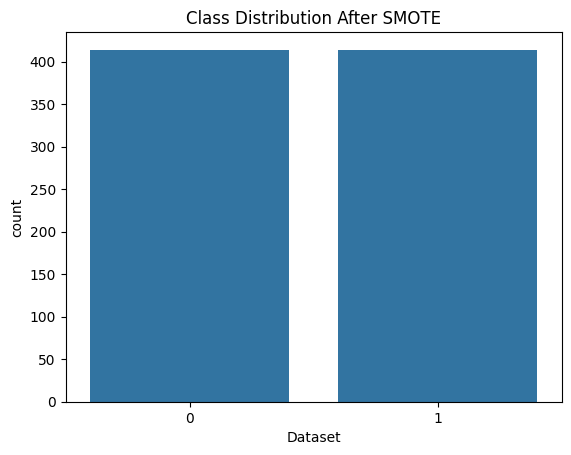

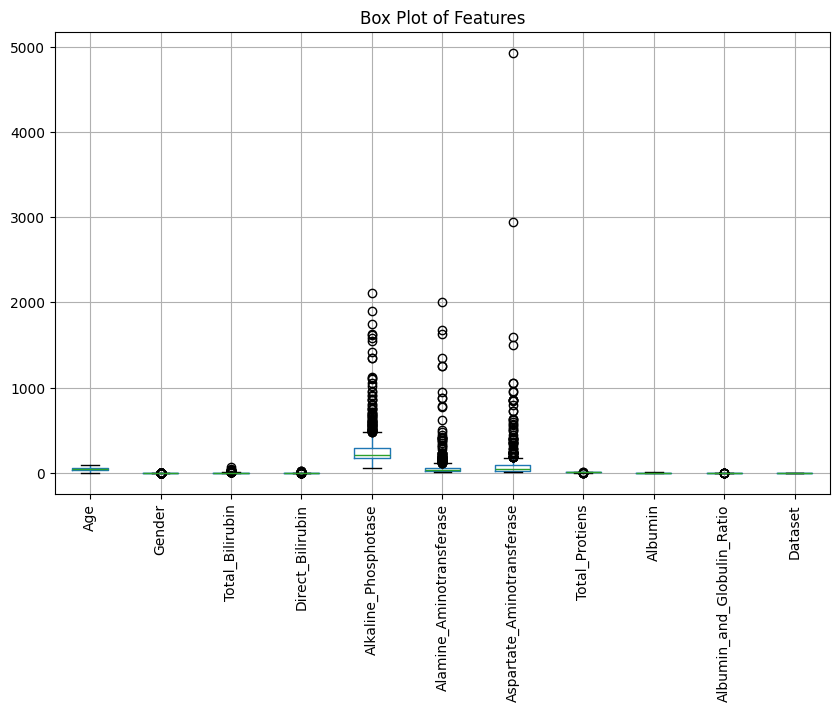

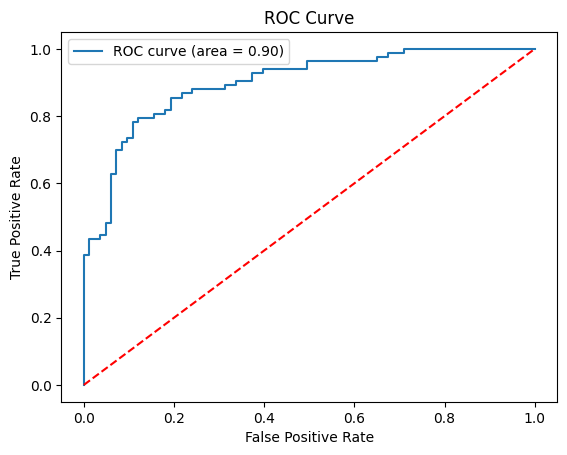

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        83
           1       0.78      0.87      0.82        83

    accuracy                           0.81       166
   macro avg       0.82      0.81      0.81       166
weighted avg       0.82      0.81      0.81       166



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Load dataset
df = pd.read_csv('indian_liver_patient.csv')

# Handling missing values
df.dropna(inplace=True)

# Encode categorical variables if any
if 'Gender' in df.columns:
    df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# Define features and target
X = df.drop(columns=['Dataset'])  # Assuming 'Dataset' is the target column
y = df['Dataset']

# Convert target variable {1,2} to {0,1}
y = y.map({1: 0, 2: 1})

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

# Train optimized XGBoost model
xgb = grid_search.best_estimator_
xgb.fit(X_train, y_train)

# Save the trained model
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(xgb, file)

# Predictions
y_pred = xgb.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
feature_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.show()

# Class Distribution
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
df.boxplot(rot=90)
plt.title('Box Plot of Features')
plt.show()

# ROC Curve
probs = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))
